## Multi-Objective Optimization
Version 0.0.2
(c) Larry Lueer, Vincent LeCorre, i-MEET 2021-2022

In [1]:
# necessary imports

#%matplotlib notebook # switch this on when on JupyterHub
#%matplotlib inline

#from imeet import * # old packages
import sys
#sys.path.append('/home/larryl/Desktop/PVLC_notebook') 
# sys.path.append('/home/larryl/Documents/PVLC_notebook')
sys.path.append('/home/larryl/Documents/vscodeprojs/boar')
from boar import * # new package
import pandas as pd
from numpy.random import default_rng

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)



In [2]:
# **************** MODEL FUNCTION ***********

def model(X, params):
    """Model function to be used by the optimizer

    Use this model to fit arrays, e.g. from sets of IV curves or spectra
    If you want to fit scalars, use the notebook MO_benchmar_scalar

    Let's say, this is Hooke's law with a temperature dependent force constant 

    Args:
        X (ndarray): Experimental conditions (things you know because you imposed them)
        You measured the force of the spring at 3 different elongations (0,1,2 cm)
        and at two different temperatures (0.1 and 0.5K )
        the array X should then look like this:
        np.array(
        [[0,0.1],
         [1,0.1],
         [2,0.1],
         [0,0.5],
         [1,0.5],
         [2,0.5]])
        This is standard convention for optimizers in scipy and scikit-optimize

        params (list): Fitparam() objects (things you want to know by fitting the data)
    Returns:
        y (ndarray): the target parameter 
        calcuated for each row in X according to the elongation and temperature)
    """

    a = [pp.val for pp in params if pp.name=='a'][0] # find Fitparam named 'a'
    b = [pp.val for pp in params if pp.name=='b'][0] # find Fitparam named 'b'
    c = [pp.val for pp in params if pp.name=='c'][0] # find Fitparam named 'c'

    # let's say, a is the Force constant at T=0°C, b is the first coefficient of the Taylor expansion
    # for the temperature dependence and thus enters additively into the formula
    # and c is the first coefficient of the Taylor expansion for the relative humidity dependence (RH)
    # which also enters additively.

    # problem is: we do not know the RH, so we were not able to vary it
    # we will find complete linear dependence between a c
    # but we will still recover the temperature coefficient b
    
    b1 = b*X[:,1] # b1 depends only on temperature; first coefficient of Taylor expansion (unit N/m * K)
    y = (a+b1+c)*X[:,0]# therefore the linear slope along X[:,0] depends on temperature (unit N)
    #y = (a+b1)*X[:,0]# This version is independent of c
    return y

def model2(X,params):
    # proxy experiment for relative humidity
    c = [pp.val for pp in params if pp.name=='c'][0] # find Fitparam named 'c'
    y = c # in the simplest case, assume that your proxy experiment directly yields c
        # but this could be any complex relationship
        # note that you don't care about X in this case
    return [y] # make sure you return an array-like object, even if it contains a single scalar


In [3]:
# define Fitparameters
truevals = {'a': 5, 'b': 5, 'c': 1} # these are the true values of the parameters
a = Fitparam(name = 'a',val=truevals['a'],relRange=1,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
b = Fitparam(name = 'b',val=truevals['b'],relRange=1,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
c = Fitparam(name = 'c',val=truevals['c'],relRange=1,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
params = [a,b,c]

In [4]:
# create some fake data

outliers = False 
systematic_deviations = False
thr = 100 # threshold for onset of nonlinear behavior (only for systematic_deviations)


dimensions = ['time', 'intensity']
t  = np.linspace(0,10,101)
#L = np.linspace(0.1,10,1)
L = [0.1,0.5] 
X = np.array([[x,y] for x in L for y in t])
X = np.fliplr(X)
y = model(X,params)
rng = default_rng()#
noise = rng.standard_normal(y.shape) * 1
#noise = noise * X[:,1] # try this: higher T - higher noise  
y+=noise # add some noise
#y[y>0] = y[y>0]**1.2 # add some spurious non-linearity (can be handled using weights)

if outliers:
    for ii in range(len(t)*len(L))[::50]:
        y[ii] = 100 # produce a periodic artifact ( can be handled using loss functions)
if systematic_deviations:
    y = thr*(np.exp(y/thr)-1)

# Finally, assume a known relative humidity
RH = 1



In [5]:
# create target & start MO

#provide a wrong startVal to make it a bit harder for the optimizer

a.startVal = 3
b.startVal = 3
c.startVal = 0.8
use_weighting = True
thrw = 1

if use_weighting:
    weight = y*0+1
else:
    weight =1

target = {'model':model,'data':{'X':X,'y':y, 'X_dimensions':['elongation','T'],
                                'X_units':['m','°C'],'y_dimension':'Force',
                                'y_unit':r'N'},
            'params':params, 'weight':weight}


X2 = X[0,:] # same number of columns, just one row
y2 = np.array([RH]) # make sure y is always an array-like object
weight2 = y2*0+10
target2 = {'model':model2,'data':{'X':X2,'y':y2, 'X_dimensions':['elongation','T'],
                                'X_units':['m','°C'],'y_dimension':'Rel Humidity',
                                'y_unit':r'%RH'},
            'params':params, 'weight':weight2}

# use this when you want to fit both targets
mo = MultiObjectiveOptimizer(targets = [target,target2])

# use this when you want to fit just a single target
#mo = MultiObjectiveOptimizer(targets = [target])

# First, use a gradient based optimizer
kwargs = {'ftol':1e-8, 'xtol':1e-6, 'gtol': 1e-8, 'diff_step':0.001,
                         'loss':'linear','max_nfev':5000}
r = mo.optimize_curvefit(kwargs=kwargs) # use a gradient based optimizer


a = 4.979844412602283 +- 0.10713076274108614
b = 4.98432150902332 +- 0.0636062567355358
c = 1.0000000000013693 +- 0.10464727449400618


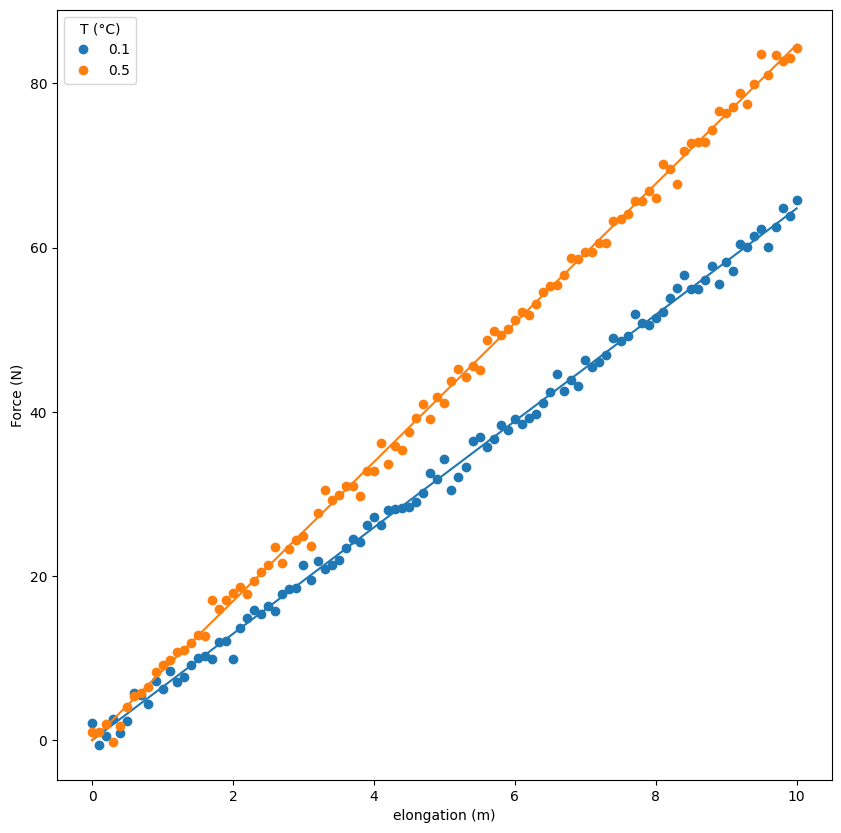

In [6]:
# plot the result from the gradient based optimzer
popt = r['popt']
std = np.sqrt(np.diag(r['pcov']))
yfit = model(X,params)


for p in params:
    print(p.name,'=', p.val, '+-',p.std)

x_dims = target['data']['X_dimensions']   
x_units = target['data']['X_units'] 
y_dim = target['data']['y_dimension']  
y_unit = target['data']['y_unit']    

xnames = [x_dim + f' ({x_unit})' for x_dim,x_unit in zip(x_dims,x_units)]
yname = y_dim + f' ({y_unit})'
plt.figure(figsize=(10,10))
for ii,L0 in enumerate(L): 
    pick = X[:,1]==L0
    xp = X[pick,0]
    yp = y[pick]
    plt.plot(xp,yp,'o',c='C'+str(ii),label=L0)
    yf = yfit[pick]
    plt.plot(xp,yf,c='C'+str(ii))
plt.xlabel(xnames[0])
plt.ylabel(yname)
plt.legend(title=xnames[1])



In [ ]:
# Then, try a Bayesian Optimizer
gp = 'GP'

ii=0
mo.targets = [target,target2]
mo.params = params
mo.warmstart = 'None'


kwargs = {'check_improvement':'relax','max_loop_no_improvement':10,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':100,'gaussfilt':3,'logscale':False,'vmin':1e-100,'zoom':0,'min_prob':1e-40,
                    'clear_axis':False,'True_values':truevals,'show_points':True,'savefig':True,
                    'figname':'param_posterior'+str(ii),'figsize':(10,10)}
kwargs_plot_obj = {'zscale':'linear'}

r = mo.optimize_sko_parallel(n_jobs=4,n_yscale=20, n_BO=40, n_initial_points = 40,n_BO_warmstart=5,
                             n_jobs_init=None,loss='linear',threshold=1000,kwargs=kwargs,verbose=True,
                            base_estimator = gp,show_objective_func=True,kwargs_plot_obj=kwargs_plot_obj,show_posterior=True,
                            kwargs_posterior=kwargs_posterior)


In [ ]:
for p in params:
    print(p.name,'=', p.val, '+-',p.std)

In [ ]:
# plot the result from the sko
popt = r['popt']
a.val = r['popt'][0]
# std2 = np.sqrt(np.diag(r['pcov']))

print('popt',r['popt'])
# print('pcov',r['pcov'])
# print('std',std2)

data = []
columns = [] # for output
for ii,L0 in enumerate(L): 
    pick = X[:,1]==L0
    xp = X[pick,0]
    yp = y[pick]
    plt.plot(xp,yp,'o',c='C'+str(ii))
    yf = yfit[pick]
    plt.plot(xp,yf,c='C'+str(ii))
    data = data + [xp,yp,yf]
    columns = columns + ['x','yexp','yfit']
plt.xlabel(xnames[0])
plt.ylabel(yname)

In [ ]:
# produce output excel file ( copied from Rong's notebook TRPL_simple, not adapted to work here)
ag = Agent()
param_dict = ag.get_param_dict(params) # get fitparameters (and fixed ones)
datax = np.array(data).T

#yfit = da.model_TRPL(X,params,state=0,const = 'kr')

# go in first sheet for first sheet
#data = np.hstack((texp.reshape(-1,1),yexp.reshape(-1,1),yfit.reshape(-1,1)))
# parameters go in second sheet
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]

fn_xlsx = 'fits_testdata.xlsx'

with pd.ExcelWriter(fn_xlsx, mode='w') as writer:
    df = pd.DataFrame(datax,columns=columns)
    df.to_excel(writer, sheet_name = 'data') 
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = 'params') 